
# Task 2: Quantitative Analysis with TA-Lib and PyNance 
## Objectives:
- Load & prepare OHLCV data
- Compute technical indicators (SMA, EMA, RSI, MACD, ATR, Bollinger Bands) using TA-Lib
- Compute Sharpe ratio, Value at Risk placeholder
- Visualize price, indicators, and performance

## KPIs:
- Accuracy of indicators
- Completeness of Data Analysis

# Imports, Constants, and Path Definitions 

In [69]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as psub
import plotly.io as pio

print("Default renderer:", pio.renderers.default)
pio.renderers.default = "notebook"

## Setup Pathz
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
scripts_path = project_root / 'scripts'
scripts_path_str = str(scripts_path)
if scripts_path_str not in sys.path:
    sys.path.insert(0, scripts_path_str)

# Local modules
from data_loader import DataLoader
from quant_analysis import QuantAnalysis, MovingAverageConfig, MACDConfig, RSIConfig, ATRConfig, BollingerBandsConfig


plt.style.use("seaborn-v0_8")
sns.set_context("talk")
TICKERS = ["AAPL", "AMZN", "MSFT", "NVDA","GOOG", "META"]
DATA_DIR = Path("../data")
PRICE_PATH = DATA_DIR / f"{TICKERS[1]}.csv"

Default renderer: notebook


## 1. Load & Prepare Data

In [70]:
loader = DataLoader()
price_df = loader.load_stock_price(PRICE_PATH, preview=False)
price_df.head()
### Basic inspection
print("Columns:", price_df.columns.tolist())
print(price_df.select_dtypes(include="number").describe())

Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
             Close         High          Low         Open        Volume
count  3774.000000  3774.000000  3774.000000  3774.000000  3.774000e+03
mean     59.408094    60.116390    58.669489    59.423925  9.185184e+07
std      54.918541    55.610783    54.233978    54.953769  6.057553e+07
min       2.422000     2.505000     2.381500     2.428000  1.762600e+07
25%      12.194500    12.300250    12.042125    12.146625  5.586350e+07
50%      36.359499    36.489000    36.004000    36.322500  7.520600e+07
75%      96.638248    97.750000    95.379747    96.663498  1.086060e+08
max     186.570496   188.654007   184.839493   187.199997  1.166116e+09


## 2. Add Technical Indicators

In [71]:
# Selectively enabling indicators by passing configs.
qa = QuantAnalysis(periods_per_year=252)
price_ind_df = qa.add_indicators(
    price_df,
    prefix="TA_",
    ma_cfg=MovingAverageConfig(sma_period=20, ema_period=20),
    rsi_cfg=RSIConfig(period=14),
    macd_cfg=MACDConfig(fast=12, slow=26, signal=9),
    atr_cfg=ATRConfig(period=14),
    bbands_cfg=BollingerBandsConfig(period=20, nbdevup=2.0, nbdevdn=2.0, matype=0),
)
price_ind_df.tail()

,Date,Close,High,Low,Open,Volume,TA_SMA_20,TA_EMA_20,TA_RSI_14,TA_MACD,TA_MACD_signal,TA_MACD_hist,TA_ATR_14,TA_BB_upper,TA_BB_mid,TA_BB_lower
3769,2023-12-22,153.419998,154.350006,152.710007,153.770004,29514100,148.578999,148.860492,64.115558,3.135958,2.873052,0.262905,3.192795,154.696716,148.578999,142.461283
3770,2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200,148.863000,149.293779,64.085644,3.118650,2.922172,0.196478,3.032595,155.314929,148.863000,142.411071
3771,2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700,149.178500,149.679133,63.860893,3.063965,2.950530,0.113434,2.934553,155.854273,149.178500,142.502726
3772,2023-12-28,153.380005,154.080002,152.949997,153.720001,27057000,149.531499,150.031597,63.938728,2.989395,2.958303,0.031092,2.805656,156.311164,149.531499,142.751835
3773,2023-12-29,151.940002,153.889999,151.029999,153.100006,39823200,149.824000,150.213350,59.012257,2.782032,2.923049,-0.141017,2.809538,156.488309,149.824000,143.159691


In [72]:
## 3. Compute Returns & Performance Metrics

In [73]:
price_ret_df = qa.compute_returns(price_ind_df, method="simple")

sharpe = qa.sharpe_ratio(price_ret_df)
sortino = qa.sortino_ratio(price_ret_df)
mdd = qa.max_drawdown(price_ret_df)
calmar = qa.calmar_ratio(price_ret_df)

metrics = {
    "Sharpe (annualized)": sharpe,
    "Sortino (annualized)": sortino,
    "Max Drawdown": mdd,
    "Calmar": calmar,
}
metrics

{'Sharpe (annualized)': 0.9473723497512566,
 'Sortino (annualized)': 1.4234859950680308,
 'Max Drawdown': -0.561452632532826,
 'Calmar': 97.78456300252394}

## 4. Visualizations

## SMA & EMA

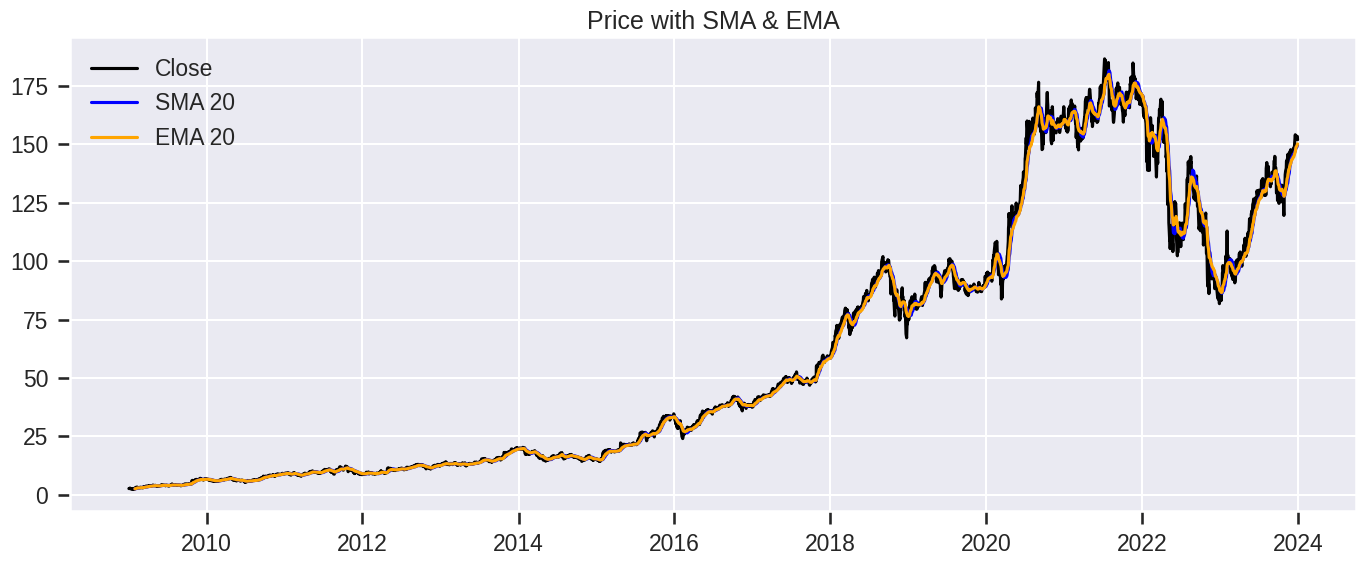

In [74]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
ax.plot(price_ret_df["Date"], price_ret_df["TA_SMA_20"], label="SMA 20", color="blue")
ax.plot(price_ret_df["Date"], price_ret_df["TA_EMA_20"], label="EMA 20", color="orange")
ax.set_title("Price with SMA & EMA")
ax.legend()
plt.tight_layout()
plt.show()

## RSI

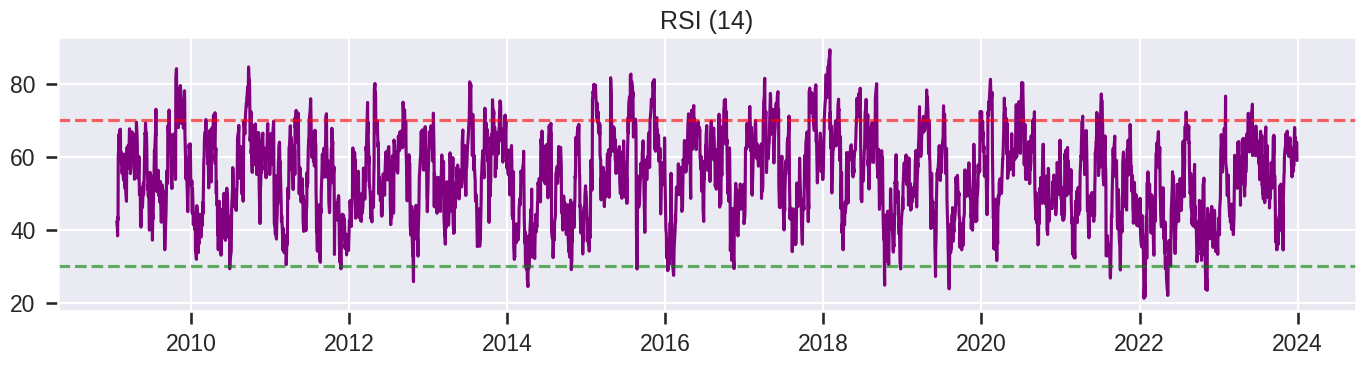

In [75]:
plt.figure(figsize=(14,4))
plt.plot(price_ret_df["Date"], price_ret_df["TA_RSI_14"], color="purple")
plt.axhline(70, color="red", linestyle="--", alpha=0.6)
plt.axhline(30, color="green", linestyle="--", alpha=0.6)
plt.title("RSI (14)")
plt.tight_layout()
plt.show()

## MACD Interactive

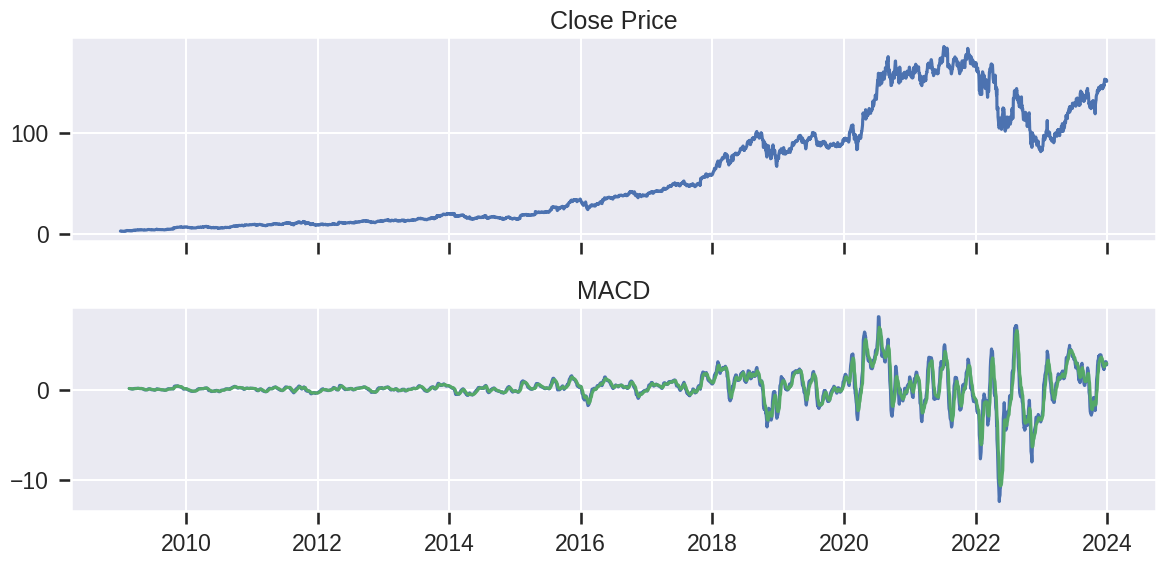

In [76]:
#  Uncomment for interactive version
# fig = psub.make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.6, 0.4])
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["Close"], name="Close", line=dict(color="black")), row=1, col=1)
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD"], name="MACD", line=dict(color="purple")), row=2, col=1)
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD_signal"], name="Signal", line=dict(color="orange")), row=2, col=1)
# fig.update_layout(height=600, title="Price & MACD")
# fig.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(price_ret_df["Date"], price_ret_df["Close"])
ax1.set_title("Close Price")

ax2.plot(price_ret_df["Date"], price_ret_df["TA_MACD"])
ax2.plot(price_ret_df["Date"], price_ret_df["TA_MACD_signal"])
ax2.set_title("MACD")

plt.tight_layout()
plt.savefig("macd_static.png")
plt.show()

## Bollinger Bands

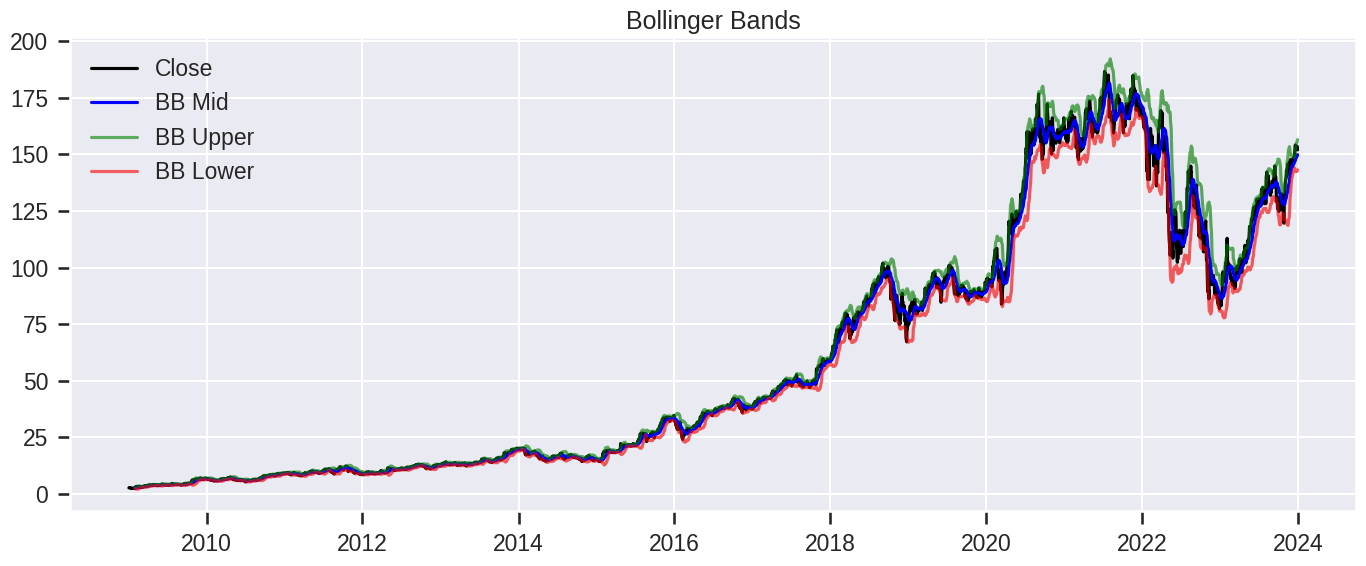

In [77]:
plt.figure(figsize=(14,6))
plt.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_mid"], label="BB Mid", color="blue")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_upper"], label="BB Upper", color="green", alpha=0.6)
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_lower"], label="BB Lower", color="red", alpha=0.6)
plt.fill_between(price_ret_df["Date"], price_ret_df["TA_BB_lower"], price_ret_df["TA_BB_upper"], color="gray", alpha=0.1)
plt.title("Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()

## Cumulative Return & Drawdown

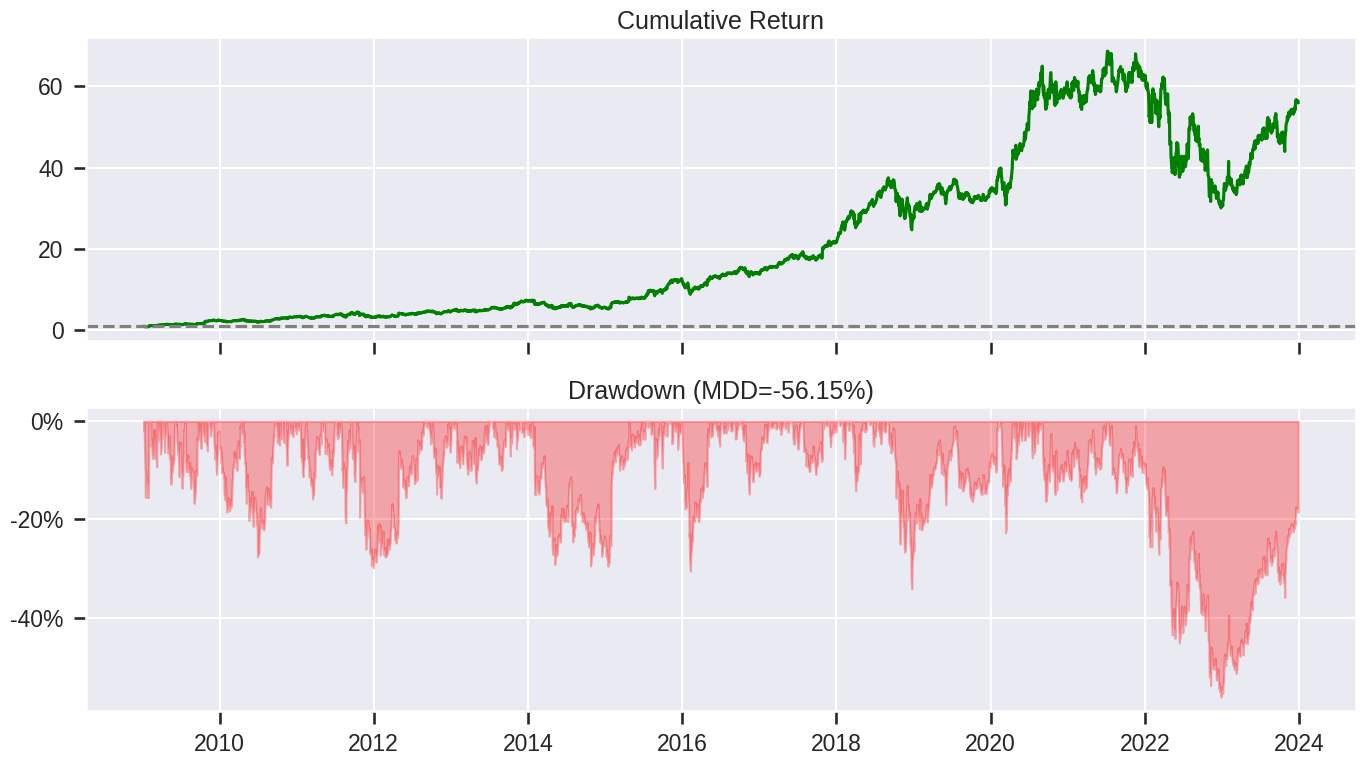

In [78]:
equity = price_ret_df["cumulative_return"]
running_max = equity.cummax()
drawdown = (equity - running_max) / running_max

fig, axes = plt.subplots(2, 1, figsize=(14,8), sharex=True)
axes[0].plot(price_ret_df["Date"], equity, color="green")
axes[0].set_title("Cumulative Return")
axes[0].axhline(1.0, color="gray", linestyle="--")

axes[1].fill_between(price_ret_df["Date"], drawdown, 0, color="red", alpha=0.3)
axes[1].set_title(f"Drawdown (MDD={mdd:.2%})")
axes[1].yaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.tight_layout()
plt.show()

## 5. Export

In [79]:
price_ret_df["ticker"] = f"{TICKERS[1]}"
price_ret_df.to_csv(f"../data/{TICKERS[1]}_task2_price_indicators.csv", index=False)